# DELE CA2 Part A - GAN

## Import General Dependencies

In [102]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from matplotlib import pyplot as plt
import os
from abc import ABC, abstractmethod
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob
from PIL import Image
from tensorflow.keras.models import load_model
import imageio
import seaborn as sns
from scipy.linalg import sqrtm
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from skimage.transform import resize

## Declare Global Constants

In [29]:
# Define global configuration variables
ARTIFACT_STORE = '../gans/'

CIFAR10_CLASSES = ('Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')

## General Utilities

In [7]:
def squeeze_images(img):
    img = img.astype(np.float64)
    img /= 127.5
    img -= 1.0
    return img

In [8]:
def unsqueeze_images(img):
    img += 1.0
    img *= 127.5
    img = img.astype(np.uint8)
    return img

In [9]:
def load_data():
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    X = np.concatenate((X_train, X_test), axis=0)
    y = np.concatenate((y_train, y_test), axis=0)
    return X, y

In [10]:
def partition_data(class_):
    X, y = load_data()
    index = CIFAR10_CLASSES.index(class_)
    return X[y.flatten() == index]

In [11]:
def sub_partition_data(class_, n_partitions=10, n_samples=8, drop=None):
    X = partition_data(class_)
    feat = X.reshape(X.shape[0], -1)

    X_reduced = PCA(n_components=10, random_state=0).fit_transform(feat)

    model = KMeans(n_clusters=n_partitions, random_state=0)
    mask = model.fit_predict(X_reduced)

    if drop:
        return X[~np.isin(mask, drop)]
    else:
        fig, ax = plt.subplots(n_partitions, n_samples, figsize=(12, 8))

        for r in range(n_partitions):
            group = X[mask == r]
            ax[r, 0].set_title(f'Group {r} - Count: {group.shape[0]}')

            for c in range(n_samples):
                ax[r, c].imshow(group[r * n_partitions + c])
                ax[r, c].axis('off')

        plt.show()

In [12]:
def sharpen_images(imgs, degree=2.0):
    from PIL import Image, ImageEnhance
    lst = []
    if len(imgs.shape) == 4:
        for img in imgs:
            im = Image.fromarray(img)
            enhancer = ImageEnhance.Sharpness(im)
            im = enhancer.enhance(degree)
            lst.append(np.expand_dims(np.array(im), axis=0))
        return np.concatenate(lst, axis=0)
    im = Image.fromarray(imgs)
    enhancer = ImageEnhance.Sharpness(im)
    im = enhancer.enhance(degree)
    return np.array(im)

In [13]:
def preview_sharpening_effect(sharpening_degree=2.0, n_samples=5):
    X, _ = load_data()
    samples = X[np.random.randint(0, X.shape[0], n_samples)]
    fig, ax = plt.subplots(n_samples, 2)
    for r in range(n_samples):
        sample = samples[r]
        ax[r, 0].imshow(sample)
        ax[r, 0].axis('off')
        ax[r, 1].imshow(sharpen_images(sample, degree=sharpening_degree))
        ax[r, 1].axis('off')
    plt.show()

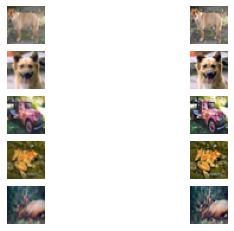

In [14]:
preview_sharpening_effect()

In [15]:
def generate_latent_points(n_samples, latent_dim=100):
    return np.random.randn(n_samples, latent_dim)

In [16]:
def generate_fake_samples(generator, batch_size, latent_dim=100):
    random_latent_vectors = generate_latent_points(batch_size, latent_dim)
    X = generator.predict(random_latent_vectors)
    return X

In [17]:
def generate_real_samples(batch_size, X):
    samples = np.random.randint(0, X.shape[0], batch_size)
    return X[samples]

In [18]:
def smoothen_labels(y, range_=(0.8, 1.1)):
    return y - 1 + range_[0] + np.random.random(y.shape) * (range_[1] - range_[0])

In [47]:
def generate_gif(class_, rows=5, cols=6, n_frames=20):
    import matplotlib

    matplotlib.use('Agg')

    model_dir = ARTIFACT_STORE + class_ + '_dcgan/generator/*.h5'
    filenames = []

    random_latent_vectors = generate_latent_points(n_samples=rows * cols)
    for i, model_file in enumerate(sorted(glob.glob(model_dir), key=lambda m: int(m.split('\\')[-1].split('.')[0]))):
        model = load_model(model_file, {'ConvTransposeBlock': ConvTransposeBlock}, compile=False)
        X = unsqueeze_images(model.predict(random_latent_vectors))
        fig, ax = plt.subplots(rows, cols)
        for r in range(rows):
            for c in range(cols):
                ax[r, c].imshow(X[r * rows + c])
                ax[r, c].axis('off')
        tmp_file = f'{i}.png'
        for _ in range(n_frames):
            filenames.append(tmp_file)
        fig.suptitle(f'{(i + 1) * 20} epochs')
        plt.savefig(tmp_file)
        plt.close()

    # build gif
    with imageio.get_writer(f'../images/gif/{class_}.gif', mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
        
    # Remove files
    for filename in set(filenames):
        os.remove(filename)

In [33]:
def generate_images(class_, version, sharpening_degree=0.95):
    model_file = f'{ARTIFACT_STORE}{class_}_dcgan/generator/{version}.h5'
    model = load_model(model_file, {'ConvTransposeBlock': ConvTransposeBlock}, compile=False)

    for i in range(5):
        X = generate_fake_samples(generator=model, batch_size=25)
        X = unsqueeze_images(X)
        X = sharpen_images(X, degree=sharpening_degree)
        fig, ax = plt.subplots(4, 5)
        for r in range(4):
            for c in range(5):
                ax[r, c].imshow(X[r * 4 + c])
                ax[r, c].axis('off')
        fig.savefig(f'../images/png/{class_}_{i}.png')
        plt.close()

## DCGAN

In [21]:
class BaseGAN(ABC):
    def __init__(self, name, artifact_directory, input_shape, latent_dim):
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.name = name
        self.artifact_directory = artifact_directory

        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        self.gan = self.build_gan()

        Path(artifact_directory + 'checkpoints').mkdir(parents=True, exist_ok=True)
        Path(artifact_directory + 'generated_images').mkdir(parents=True, exist_ok=True)

        checkpoint_dir = f'{artifact_directory}checkpoints'
        checkpoint = tf.train.Checkpoint(
            generator=self.generator,
            discriminator=self.discriminator,
            gan = self.gan
        )
        prev_generated_images = os.listdir(f'{artifact_directory}generated_images')
        prev_generated_images = list(filter(lambda im: name in im, prev_generated_images))

        self.warm_start = 0

        if len(prev_generated_images) > 0:
            prev_trained_epochs = [int(im.replace(f'{name}_', '').split('.')[0]) for im in prev_generated_images]
            self.warm_start = sorted(prev_trained_epochs)[-1]
        
        self.checkpoint_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=10)
        if self.checkpoint_manager.latest_checkpoint:
            checkpoint.restore(self.checkpoint_manager.latest_checkpoint)
            print ('Resuming training from last checkpoint...')
    
    @abstractmethod
    def build_discriminator(self):
        pass

    @abstractmethod
    def build_generator(self):
        pass
    
    @abstractmethod
    def build_gan(self):
        pass
    
    def save_images(self, epoch, rows=5, cols=5):
        noise = np.random.randn(rows * cols, self.latent_dim)
        gen_imgs = self.generator.predict(noise)
        gen_imgs = unsqueeze_images(gen_imgs)

        fig, axs = plt.subplots(rows, cols)
    
        for i in range(rows):
            for j in range(cols):
                axs[i, j].imshow(gen_imgs[i * rows + j])
                axs[i, j].axis('off')

        fig.savefig(f'{self.artifact_directory}generated_images/{self.name}_{epoch}.png')
        plt.close()

    def checkpoint(self, epoch, save_gen=True, save_disc=True, save_gan=True, **kwargs):
        self.save_images(epoch=epoch, **kwargs)
        if save_gen:
            self.generator.save(f'{self.artifact_directory}generator/{epoch}.h5')
        if save_disc:
            self.discriminator.save(f'{self.artifact_directory}discriminator/{epoch}.h5')
        if save_gan:
            self.gan.save(f'{self.artifact_directory}gan/{epoch}.h5')
        self.checkpoint_manager.save()

    def summarize_performance(self, X, epoch, n_samples, y_real=None):
        if y_real is None:
            y_real = tf.ones(shape=(n_samples, 1))
        y_fake = tf.zeros(shape=(n_samples, 1))
        X_real = generate_real_samples(n_samples, X)
        d_loss_real, acc_real = self.discriminator.evaluate(X_real, y_real, verbose=0)
        X_fake = generate_fake_samples(self.generator, n_samples, self.latent_dim)
        d_loss_fake, acc_fake = self.discriminator.evaluate(X_fake, y_fake, verbose=0)
        print(f'\nDiscriminator Accuracy: Real ({acc_real * 100.0}%) Fake ({acc_fake * 100.0}%)')
        print(f'Discriminator Loss: Real ({d_loss_real}) Fake ({d_loss_fake})')
    
    @abstractmethod
    def train(self):
        pass

In [22]:
class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, filters=32, init=None, **kwargs):
        super(ConvBlock, self).__init__(**kwargs)
        self.filters = filters
        self.conv = Conv2D(filters=filters, kernel_size=4, strides=2, padding='same', kernel_initializer=init)
        self.act = LeakyReLU(alpha=0.2)
    
    def call(self, x):
        x = self.conv(x)
        x = self.act(x)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "filters": self.filters
        })
        return config

In [23]:
class ConvTransposeBlock(tf.keras.layers.Layer):
    def __init__(self, filters=32, init=None, **kwargs):
        super(ConvTransposeBlock, self).__init__(**kwargs)
        self.filters = filters
        self.conv_T = Conv2DTranspose(filters=filters, kernel_size=4, strides=2, padding='same', kernel_initializer=init)
        self.act = LeakyReLU(alpha=0.2)
    
    def call(self, x):
        x = self.conv_T(x)
        x = self.act(x)
        return x
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "filters": self.filters
        })
        return config

In [24]:
class DCGAN(BaseGAN):
    def __init__(self, class_, drop, input_shape=(32, 32, 3), latent_dim=100):
        super().__init__(name=class_ + '_dcgan',
                         artifact_directory=ARTIFACT_STORE + class_ + '_dcgan/',
                         input_shape=input_shape,
                         latent_dim=latent_dim)

        self.data_gen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True)

        self.X = sub_partition_data(class_=class_, drop=drop)
        self.X = sharpen_images(self.X, degree=2.0)
        self.X = squeeze_images(self.X)
        self.data_gen.fit(self.X)
    
    def build_discriminator(self):
        disc = Sequential(layers=[
            Input(shape=self.input_shape),
            ConvBlock(filters=64, init='he_normal'),
            ConvBlock(filters=128, init='he_normal'),
            ConvBlock(filters=128, init='he_normal'),
            ConvBlock(filters=256, init='he_normal'),
            Flatten(),
            Dropout(rate=0.4),
            Dense(units=1, activation='sigmoid')
        ])
        disc.compile(optimizer=Adam(learning_rate=2e-4, beta_1=0.5),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])
        return disc
    
    def build_generator(self):
        gen = Sequential(layers=[
            Input(shape=(self.latent_dim,)),
            Dense(units=4 * 4 * 128),
            Reshape(target_shape=(4, 4, 128)),
            ConvTransposeBlock(filters=128),
            ConvTransposeBlock(filters=128),
            ConvTransposeBlock(filters=128),
            Dropout(rate=0.2),
            Conv2D(filters=3, kernel_size=3, padding='same', activation='tanh')
        ])
        return gen

    def build_gan(self):
        self.discriminator.trainable = False
        gan = Sequential(layers=[
            self.generator,
            self.discriminator
        ])
        gan.compile(
            optimizer=Adam(learning_rate=2e-4, beta_1=0.5),
            loss='binary_crossentropy')
        return gan

    def train(self, epochs=1000, batch_size=128, n_batches=100, checkpoint_interval=20, summary_interval=1):
        y_fake = tf.zeros(shape=(batch_size, 1))
        for epoch in range(1 + self.warm_start, epochs + 1):
            for i, (X_real, y_real) in enumerate(self.data_gen.flow(self.X, tf.ones(self.X.shape[0], 1), batch_size=batch_size)):
                if i == n_batches:
                    break
                i += 1
                print(f'\rEpoch {epoch}/{epochs}: Batch {i}/{n_batches}', end='')
                self.discriminator.train_on_batch(X_real, y_real)
                X_fake = generate_fake_samples(self.generator, batch_size)
                self.discriminator.train_on_batch(X_fake, y_fake)
                X_noise = generate_latent_points(batch_size * 2)
                g_loss = self.gan.train_on_batch(X_noise, smoothen_labels(tf.ones(batch_size * 2, 1)))
            
            if epoch % checkpoint_interval == 0:
                self.checkpoint(epoch=epoch)
            
            if epoch % summary_interval == 0:
                self.summarize_performance(self.X, epoch, batch_size)

## Airplanes

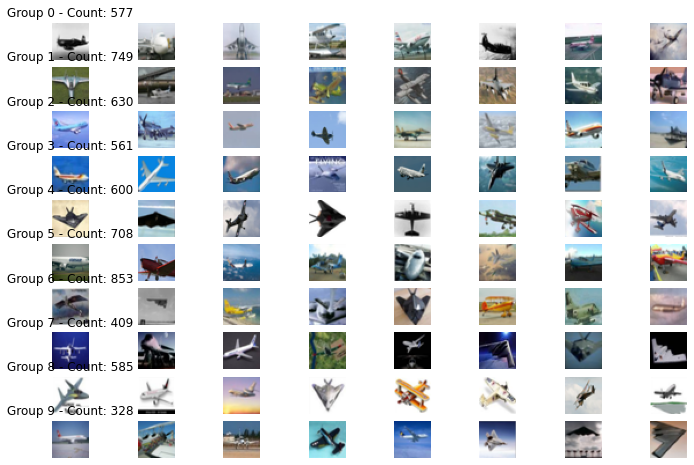

In [25]:
sub_partition_data('Airplane')

In [30]:
# airplane_gan = DCGAN(class_='Airplane', drop=[5, 6, 7])
# airplane_gan.train(260)

In [48]:
generate_gif('Airplane')

In [34]:
generate_images('Airplane', 200)

## Automobiles

C:\Users\ethanol\AppData\Local\Temp/ipykernel_14164/2801558102.py:23: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


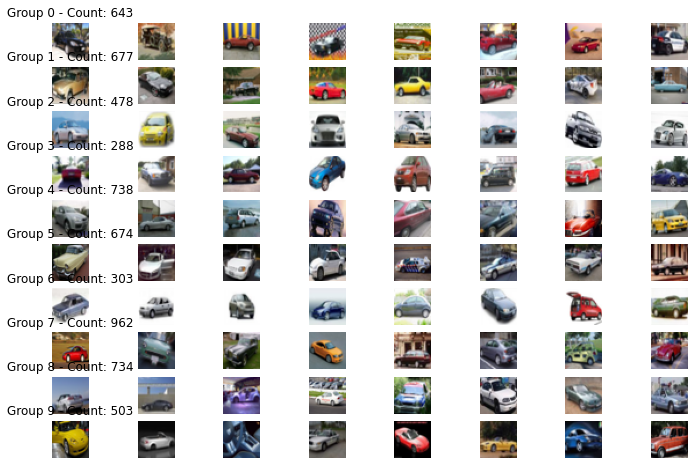

In [45]:
sub_partition_data('Automobile')

In [ ]:
# automobile_gan = DCGAN(class_='Automobile', drop=[0, 8])
# automobile_gan.train(200)

Resuming training from last checkpoint...


In [49]:
generate_images('Automobile', 180)

In [50]:
generate_gif('Automobile')

## Birds

C:\Users\ethanol\AppData\Local\Temp/ipykernel_14164/2801558102.py:23: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


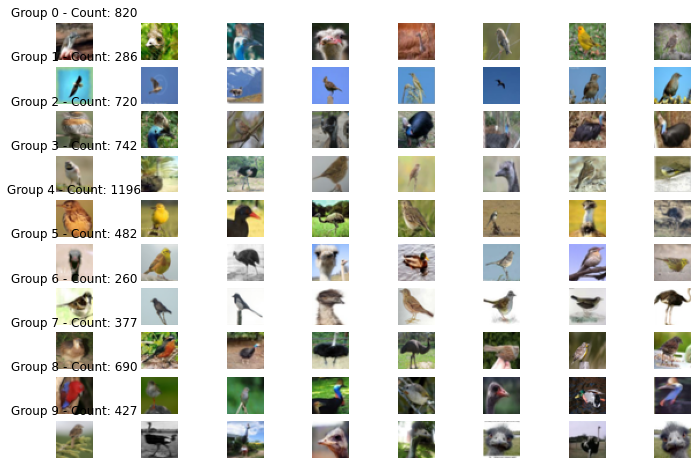

In [43]:
sub_partition_data('Bird')

In [44]:
# bird_gan = DCGAN(class_='Bird', drop=[0, 2, 7, 8, 9])
# bird_gan.train(200)

In [51]:
generate_images('Bird', 120)

In [52]:
generate_gif('Bird')

## Cats

C:\Users\ethanol\AppData\Local\Temp/ipykernel_14164/2801558102.py:23: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


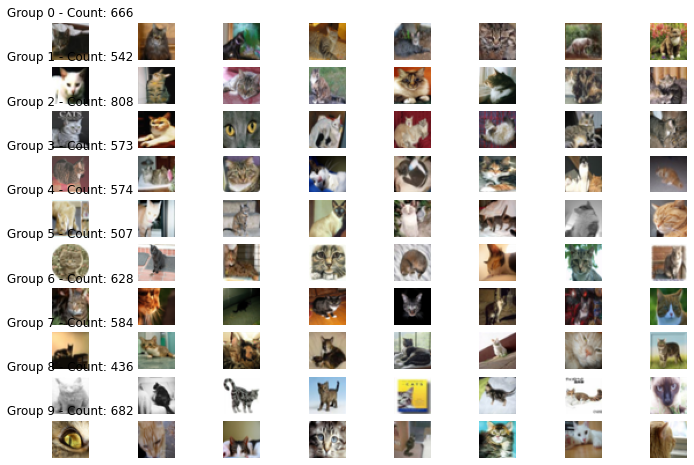

In [53]:
sub_partition_data('Cat')

In [ ]:
# cat_gan = DCGAN(class_='Cat', drop=[0, 1, 3, 4, 6, 7])
# cat_gan.train(260, checkpoint_interval=5)

In [54]:
generate_images('Cat', 230)

In [55]:
generate_gif('Cat')

## Deer

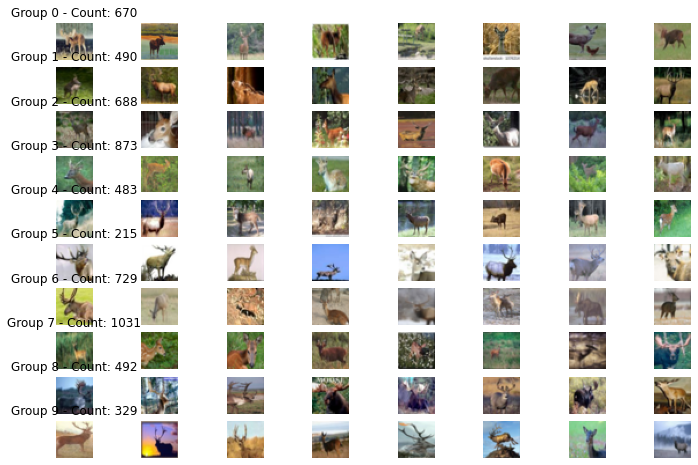

In [23]:
sub_partition_data('Deer')

In [56]:
# deer_gan = DCGAN(class_='Deer', drop=[1, 2, 6, 8, 9])
# deer_gan.train(240, checkpoint_interval=5)

In [58]:
generate_images('Deer', 175)

In [57]:
generate_gif('Deer')

## Dogs

C:\Users\ethanol\AppData\Local\Temp/ipykernel_14164/2801558102.py:23: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


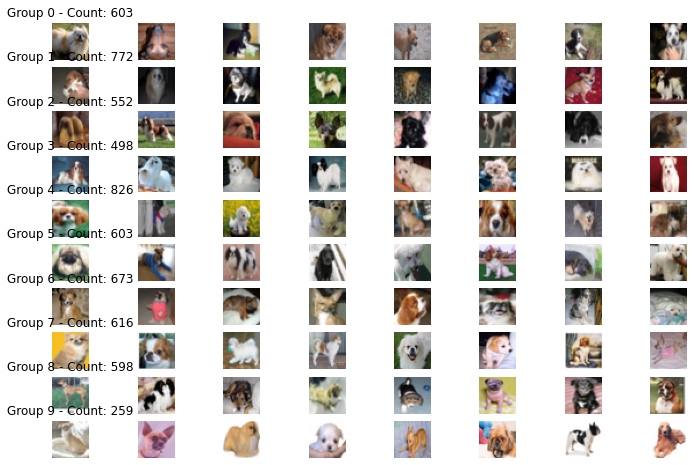

In [87]:
sub_partition_data('Dog')

In [ ]:
# dog_gan = DCGAN(class_='Dog', drop=[4])
# dog_gan.train(240, checkpoint_interval=5)

In [88]:
generate_images('Dog', 210)

In [89]:
generate_gif('Dog')

## Frogs

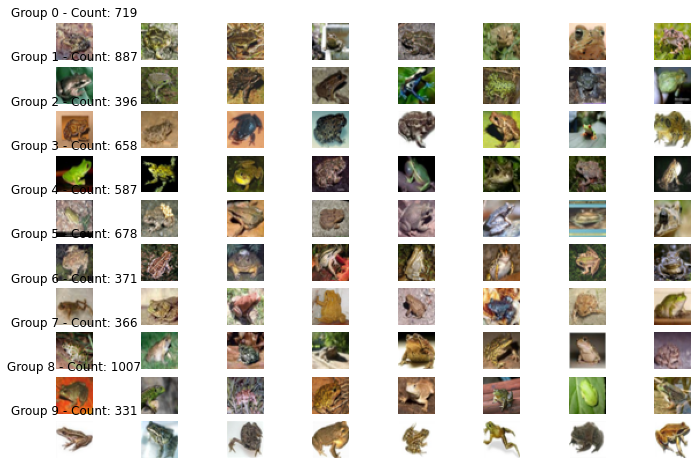

In [ ]:
sub_partition_data('Frog')

In [61]:
# frog_gan = DCGAN(class_='Frog', drop=[0, 1, 8])
# frog_gan.train(220, checkpoint_interval=10)

In [62]:
generate_images('Frog', 200)

In [63]:
generate_gif('Frog')

## Horses

C:\Users\ethanol\AppData\Local\Temp/ipykernel_14164/2801558102.py:23: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


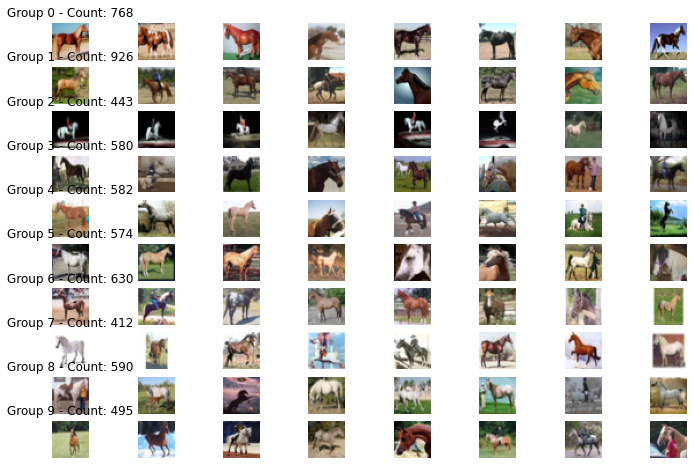

In [64]:
sub_partition_data('Horse')

In [65]:
# horse_gan = DCGAN(class_='Horse', drop=[2, 3, 4])
# horse_gan.train(240, checkpoint_interval=10)

In [66]:
generate_images('Horse', 220)

In [67]:
generate_gif('Horse')

## Ships

C:\Users\ethanol\AppData\Local\Temp/ipykernel_14164/2801558102.py:23: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


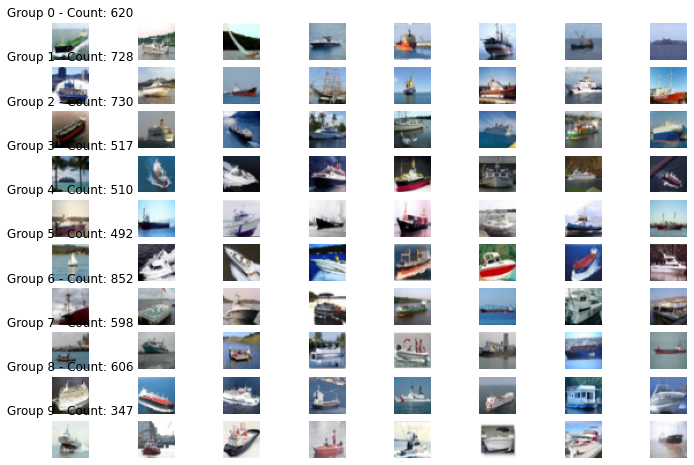

In [68]:
sub_partition_data('Ship')

In [69]:
# ship_gan = DCGAN(class_='Ship', drop=[0, 1, 6, 9])
# ship_gan.train(260, checkpoint_interval=20)

In [70]:
generate_images('Ship', 260)

In [ ]:
# gan = SpecificDCGAN(class_=' ', drop=[ ])
# gan.train(100, checkpoint_interval=20)

## Trucks

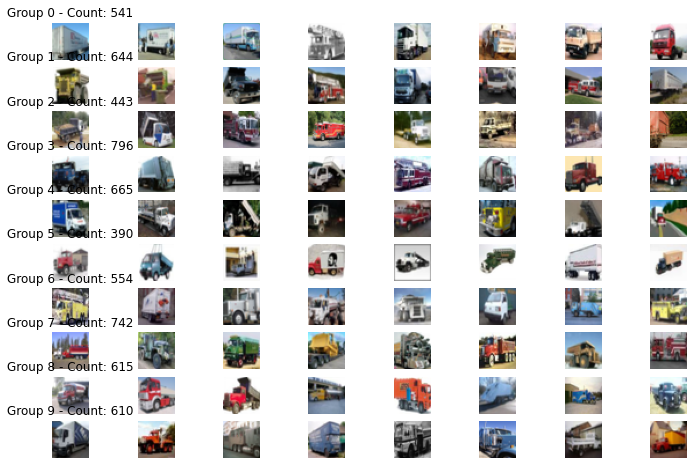

In [ ]:
sub_partition_data('Truck')

In [71]:
# truck_gan = DCGAN(class_='Truck', drop=[0, 3, 4])
# truck_gan.train(260, checkpoint_interval=20)

In [72]:
generate_images('Truck', 260)

In [73]:
generate_gif('Truck')

## Evaluation

In [78]:
def scale_images(images, new_shape):
	images_list = []
	for image in images:
		new_image = resize(image, new_shape, 0)
		images_list.append(new_image)
	return np.asarray(images_list)

In [74]:
# calculate frechet inception distance
def calculate_fid(model, images1, images2):
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [94]:
def get_fid_scores(class_, version, batch_size=10, verbose=True):
    model_file = f'{ARTIFACT_STORE}{class_}_dcgan/generator/{version}.h5'
    generator_model = load_model(model_file, {'ConvTransposeBlock': ConvTransposeBlock}, compile=False)

    inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
    real_images = generate_real_samples(batch_size=batch_size, X=partition_data(class_)).astype('float32')
    fake_images = unsqueeze_images(generate_fake_samples(generator=generator_model, batch_size=batch_size)).astype('float32')

    if verbose:
        print(f'Original Shapes - Real: {real_images.shape} Fake: {fake_images.shape}')

    real_images = preprocess_input(scale_images(real_images, (299, 299, 3)))
    fake_images = preprocess_input(scale_images(fake_images, (299, 299, 3)))

    if verbose:
        print(f'Shapes after Processing - Real: {real_images.shape} Fake: {fake_images.shape}')

    fid_real = calculate_fid(inception_model, real_images, real_images)
    
    if verbose:
        print(f'FID (real images): {fid_real}')

    fid_fake = calculate_fid(inception_model, real_images, fake_images)

    if verbose:
        print(f'FID (fake images): {fid_fake}')

    return fid_real, fid_fake

In [91]:
best_versions = {
    'Airplane': 200,
    'Automobile': 180,
    'Bird': 120,
    'Cat': 230,
    'Deer': 175,
    'Dog': 210,
    'Frog': 200,
    'Horse': 220,
    'Ship': 260,
    'Truck': 260
}

In [104]:
def plot_fid_scores(best_versions):
    class_names = []
    fid_scores = []
    for class_, version in best_versions.items():
        _, fid_score = get_fid_scores(class_, version, verbose=False)
        class_names.append(class_)
        fid_scores.append(fid_score)
    sns.barplot(x=class_names, y=fid_scores)
    plt.show()

C:\Users\ethanol\AppData\Local\Temp/ipykernel_14164/1531828251.py:9: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


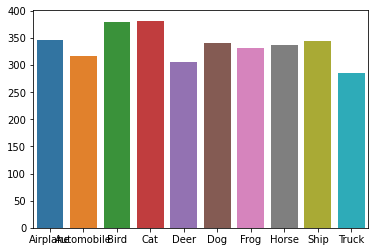

In [105]:
plot_fid_scores(best_versions)